## Tutorial on how to implement periodic boundaries

This tutorial will show how to implement Periodic boundary conditions (where particles that leave the domain on one side enter again on the other side) can be implemented in Parcels

The idea in Parcels is to do two things:
1) Extend the fieldset with a small 'halo'
2) Add a periodic boundary kernel to the `.execute`

We'll start by importing the relevant modules

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, plotTrajectoriesFile
from parcels import AdvectionRK4
from datetime import timedelta as delta
import math

We import the Peninsula fieldset; note that we need to set `allow_time_extrapolation` because the Peninsula fieldset has only one time snapshot.

In [2]:
fieldset = FieldSet.from_nemo('Peninsula_data/peninsula', allow_time_extrapolation=True)

Extending the fieldset with a halo is very simply done using the `add_periodic_halo()` method. Halos can be added either in the zonal direction, the meridional direction, or both, by setting `zonal` and/or `meridional` to `True`

In [3]:
fieldset.add_periodic_halo(zonal=True)

The other item we need is a custom Kernel that can move the particle from one side of the domain to the other.

In [4]:
def periodicBC(particle, fieldset, time, dt):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west


The fieldset constants `halo_east` and `halo_west` in the kernel above were set during the call to `add_periodic_halo()`, and store the original zonal extent of the fieldset. If we would have also used `meridional=True` in `add_periodic_halo()`, `fieldset.halo_north` and `fieldset.halo_south` would also have been added.

Now define a particle set and execute it as usual

In [5]:
pset = ParticleSet.from_line(fieldset, pclass=JITParticle, 
                             size=10, start=(0.7, 0.1), finish=(0.7, 0.4))
output_file = pset.ParticleFile(name="PeriodicParticle")
pset.execute(AdvectionRK4 + pset.Kernel(periodicBC),
             runtime=delta(hours=24), dt=delta(minutes=5),
             interval=delta(hours=1), output_file=output_file)

Compiled JITParticleAdvectionRK4periodicBC ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/e314053eec65b2ef80b5495b2134f745.so


And finally plot the particle trajectories

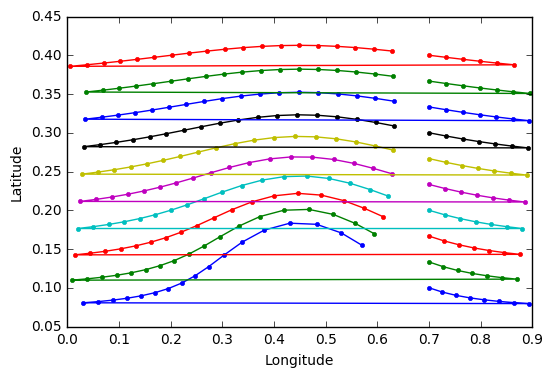

In [6]:
plotTrajectoriesFile('PeriodicParticle.nc')

We can see that the particles start at 0.7E, move eastward, and once they hit the boundary at 0.895428E, they jump to the other side of the domain (the horizontal lines). So we have periodic boundary conditions!

*As a note, one may ask why we need the halo. Why can't we use simply the `PeriodicBC` kernel? This is because, if the particle is close to the edge of the fieldset (but still in it), `AdvectionRK4` will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure `AdvectionRK4` can access these values.*